# mini BERT 만들기

vocab size를 8000으로 줄이고, 전체 파라미터 사이즈가 1M 정도가 되는 아주 작은 mini BERT 모델을 만들어 10 Epoch까지 학습시킨 모델을 만들어 보는 것

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


## Tokenizer 준비


SentencePiece 모델을 이용해 BERT의 MLM 학습용 데이터를 만드세요.

이를 위해 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만들어 보세요. BERT에 사용되는 주요 특수문자가 vocab에 포함되어야 합니다. (시간이 부족하다면 클라우드에 저장된 sentencepiece 모델을 사용하세요.)

In [2]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
spm_model = os.getcwd()+'/ko_8000'
vocab_size = 8000
spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={spm_model} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/bert_pretrain/data/kowiki.txt --model_prefix=/workspace/userdisk/project/GoingDeeper/Go06/ko_8000 --vocab_size=8007 --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/bert_pretrain/data/kowiki.txt
  input_format: 
  model_prefix: /workspace/userdisk/project/GoingDeeper/Go06/ko_8000
  model_type: BPE
  vocab_size: 8007
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 

In [3]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{spm_model}.model")

dded: freq=34016 size=700 all=783719 active=66165 piece=▁역사
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=34003 min_freq=400
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=33144 size=720 all=787243 active=42507 piece=▁만들어
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=32383 size=740 all=791538 active=46802 piece=▁시간
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=31645 size=760 all=795131 active=50395 piece=▁측
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=30941 size=780 all=798845 active=54109 piece=과의
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=30041 size=800 all=803050 active=58314 piece=도는
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=30023 min_freq=392
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=29448 size=820 all=808546 active=45099 piece=▁난
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=28836 size=840 all=813895 active=50448 piece=▁21
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=28270 size=860 all=818654 active=55207

True

## 데이터 전처리 (1) MASK 생성

BERT의 MLM에 필요한 빈칸(mask)을 학습 데이터 전체 토큰의 15% 정도로 만들어 주세요. 그 중 80%는 [MASK] 토큰, 10%는 랜덤한 토큰, 나머지 10%는 원래의 토큰을 그대로 사용

In [4]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    # 띄어쓰기 단위로 mask하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
            
    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    
    # masking
    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    
    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [5]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

## 데이터 전처리 (2) NSP pair 생성

BERT의 pretrain task인 NSP는 두 문장이 연속하는지 확인하는 것입니다. 이를 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 지정해 주세요.

두 문장 사이에 segment 처리를 해주세요. 첫 번째 문장의 segment는 0, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어주세요.

MLM과 NSP는 동시에 학습된다는 것을 염두에 두고 학습 데이터를 구성해 보세요.


In [6]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
#             print("current_chunk:", len(current_chunk), current_length, current_chunk)

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

#             print("is_next:", is_next)
#             print("tokens_a:", len(tokens_a), tokens_a)
#             print("tokens_b:", len(tokens_b), tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
#             print("tokens:", len(tokens), tokens)
#             print("segment:", len(segment), segment)
            
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
#             print("masked tokens:", len(tokens), tokens)
#             print("masked index:", len(mask_idx), mask_idx)
#             print("masked label:", len(mask_label), mask_label)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################
#             print()

            current_chunk = []
            current_length = 0
    return instances

## 데이터 전처리 (3) 데이터셋 완성

BERT pretrain 데이터셋을 생성해, json 포맷으로 저장하세요. 데이터셋의 사이즈가 크므로np.memmap을 사용해 메모리 사용량을 최소화

In [7]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [8]:
# Q. 아래 주석에 따라 코드를 완성해주세요.
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc = []  # doc 초기화
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if len(pieces) > 0:
                        doc.append(pieces)                    
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

In [9]:
pretrain_json_path = os.getcwd()+'/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [10]:
# json 확인 & 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918189

In [11]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [12]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/tmp/ipykernel_634/2049745891.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
/tmp/ipykernel_634/2049745891.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

data load early stop 128000 128000


In [13]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,   10, 1605, 3599, 1755, 3630,   41, 3644,  830, 3624, 1135,
           52, 3599,   13,   81,   87, 1501, 2247,   25, 3779, 3873, 3667,
         3631, 3813, 3873, 4196, 3636, 3779, 3601,  249, 3725, 1232,   33,
           52, 3599,    6,    6,    6, 6322, 2780,   14, 1509,  168, 3877,
          414,  165, 1697, 4290, 3873, 3703, 3683,  593,   21, 5007,  399,
         1927, 3607,    6,    6,    6,    6,    6,    6,  103, 4313, 4290,
          613, 3638, 3718,   98, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,  489,  376, 3599,    4,    6,    6,  207, 3714,
            6, 1042,  103, 3610, 3686, 3718,    6,    6,   37, 3418,  416,
          810, 3666, 3625,  131, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,  243,    6,    6,    6,  663, 1647, 3682, 3682, 3625,
          203, 3008, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([   5, 3676,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

## BERT 모델 구현

pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수, json을 config 형태로 사용하기 위한 유틸리티 함수를 먼저 만들어 두세요.

Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.

In [14]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


In [15]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))



In [16]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


In [17]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)


In [18]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


In [19]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed


In [20]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out


In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out


In [22]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val


In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


In [24]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed


In [25]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs


In [26]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [27]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

## pretrain 진행

loss, accuracy 함수를 정의하고 Learning Rate 스케쥴링을 구현한 후, 10 Epoch까지 모델 학습을 시켜보세요. 학습을 진행할 때는 배치 사이즈에 유의하세요.



In [28]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴


In [29]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy


In [30]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr
print("슝=3")

슝=3


In [31]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                   

In [32]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


## 프로젝트 결과

학습된 모델과 학습과정을 시각화해 보세요. NSP와 MLM의 loss가 안정적으로 수렴하나요? 모델이 작기 때문에 loss가 잘 수렴하지 않을 수도 있어요.



In [34]:
model_dir=os.getcwd()
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(
    x=pre_train_inputs,               # 입력 (tokens, segments)
    y=pre_train_labels,               # 정답 (labels_nsp, labels_mlm)
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights]
)
# 모델 인자에는 inputs, labels, epochs, batch size, callback 이 필요해요.

Epoch 1/10
2000/2000 [==============================] - 267s 131ms/step - loss: 19.5987 - nsp_loss: 0.6503 - mlm_loss: 18.9484 - nsp_acc: 0.5899 - mlm_lm_acc: 0.1099

Epoch 00001: mlm_lm_acc improved from -inf to 0.10990, saving model to /workspace/userdisk/project/GoingDeeper/Go06/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 264s 132ms/step - loss: 17.5316 - nsp_loss: 0.6226 - mlm_loss: 16.9090 - nsp_acc: 0.6176 - mlm_lm_acc: 0.1294

Epoch 00002: mlm_lm_acc improved from 0.10990 to 0.12936, saving model to /workspace/userdisk/project/GoingDeeper/Go06/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 265s 132ms/step - loss: 16.4406 - nsp_loss: 0.6155 - mlm_loss: 15.8252 - nsp_acc: 0.6240 - mlm_lm_acc: 0.1434

Epoch 00003: mlm_lm_acc improved from 0.12936 to 0.14335, saving model to /workspace/userdisk/project/GoingDeeper/Go06/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 265s 132ms/step - loss: 14.41

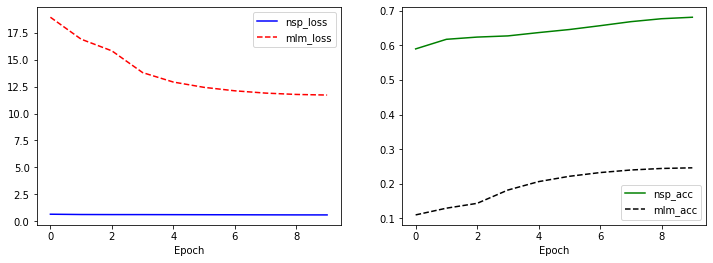

In [35]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

mlm의 loss는 줄어들지 않은 것을 확인했다.  
rep의 loss는 줄어들다가 수렴하는 것으로 보인다.  

## Inference

과학 기술 기사
```
자기장이 없는 달 뒷면의 일부 지역 암석에 강한 자기장 흔적이 남아 있는 궁금증을 해소하는 연구 결과가 나와 주목된다. 과거 대형 소행성 충돌에 따른 결과라는 분석이다.
```

```
달 자체에는 원래 자기장이 없지만, 궤도탐사선 관측 등에서는 뒷면의 암석에서 강한 자기장 흔적이 포착되고 있다. 1960~1970년대 미 항공우주국(NASA) 아폴로 임무 이후 이런 사실이 확인됐지만, 그동안 정확한 원인은 밝혀지지 않았다. 이를 설명하기 위해 달 내부에 지구처럼 용융상태 금속이 있어 자기장을 형성하는 ‘다이너모 이론’(Dynamo theory)을 적용한 가설이 제시되기도 했다. 그러나 핵이 너무 작고 특히 뒷면 암석의 강한 자기를 설명하기에는 부족하다는 지적이 제기됐다. 이 연구의 공동 연구자인 MIT 로나 오란 교수와 벤저민 와이스 교수팀이 대안 가설로 거대한 충돌이 플라스마를 생성하고, 그것이 태양 자기장을 증폭시켜 표면 암석을 자화시켰다는 가설을 내놓기도 했으나 이 역시 가능성이 작은 것으로 밝혀졌다.
```


### NSP

In [48]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def inference_nsp(text_a, text_b):
    tokens_a = vocab.encode_as_ids(text_a)
    tokens_b = vocab.encode_as_ids(text_b)

    tokens = [vocab.bos_id()] + tokens_a + [vocab.eos_id()] + tokens_b + [vocab.eos_id()]
    segments = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    # padding
    tokens = pad_sequences([tokens], maxlen=config.n_seq, padding='post')
    segments = pad_sequences([segments], maxlen=config.n_seq, padding='post')
    
    outputs_nsp, _ = pre_train_model.predict([tokens, segments])
    
    nsp_label = np.argmax(outputs_nsp, axis=-1)[0]
    print("NSP 예측:", "문장 연결 O" if nsp_label == 1 else "문장 연결 X")


In [49]:
text_a = "자기장이 없는 달 뒷면의 일부 지역 암석에 강한 자기장 흔적이 남아 있는 궁금증을 해소하는 연구 결과가 나와 주목된다."
text_b = "과거 대형 소행성 충돌에 따른 결과라는 분석이다."

inference_nsp(text_a, text_b)

NSP 예측: 문장 연결 X


In [55]:
paragraph = "달 자체에는 원래 자기장이 없지만, 궤도탐사선 관측 등에서는 뒷면의 암석에서 강한 자기장 흔적이 포착되고 있다. 1960~1970년대 미 항공우주국(NASA) 아폴로 임무 이후 이런 사실이 확인됐지만, 그동안 정확한 원인은 밝혀지지 않았다. 이를 설명하기 위해 달 내부에 지구처럼 용융상태 금속이 있어 자기장을 형성하는 ‘다이너모 이론’(Dynamo theory)을 적용한 가설이 제시되기도 했다. 그러나 핵이 너무 작고 특히 뒷면 암석의 강한 자기를 설명하기에는 부족하다는 지적이 제기됐다. 이 연구의 공동 연구자인 MIT 로나 오란 교수와 벤저민 와이스 교수팀이 대안 가설로 거대한 충돌이 플라스마를 생성하고, 그것이 태양 자기장을 증폭시켜 표면 암석을 자화시켰다는 가설을 내놓기도 했으나 이 역시 가능성이 작은 것으로 밝혀졌다."
paragraph_list = paragraph.split(". ")
for i in range(len(paragraph_list) -1):
    print(paragraph_list[i])
    print(paragraph_list[i+1])
    inference_nsp(paragraph_list[i],paragraph_list[i+1])
    print("\n")

달 자체에는 원래 자기장이 없지만, 궤도탐사선 관측 등에서는 뒷면의 암석에서 강한 자기장 흔적이 포착되고 있다
1960~1970년대 미 항공우주국(NASA) 아폴로 임무 이후 이런 사실이 확인됐지만, 그동안 정확한 원인은 밝혀지지 않았다
NSP 예측: 문장 연결 O


1960~1970년대 미 항공우주국(NASA) 아폴로 임무 이후 이런 사실이 확인됐지만, 그동안 정확한 원인은 밝혀지지 않았다
이를 설명하기 위해 달 내부에 지구처럼 용융상태 금속이 있어 자기장을 형성하는 ‘다이너모 이론’(Dynamo theory)을 적용한 가설이 제시되기도 했다
NSP 예측: 문장 연결 X


이를 설명하기 위해 달 내부에 지구처럼 용융상태 금속이 있어 자기장을 형성하는 ‘다이너모 이론’(Dynamo theory)을 적용한 가설이 제시되기도 했다
그러나 핵이 너무 작고 특히 뒷면 암석의 강한 자기를 설명하기에는 부족하다는 지적이 제기됐다
NSP 예측: 문장 연결 X


그러나 핵이 너무 작고 특히 뒷면 암석의 강한 자기를 설명하기에는 부족하다는 지적이 제기됐다
이 연구의 공동 연구자인 MIT 로나 오란 교수와 벤저민 와이스 교수팀이 대안 가설로 거대한 충돌이 플라스마를 생성하고, 그것이 태양 자기장을 증폭시켜 표면 암석을 자화시켰다는 가설을 내놓기도 했으나 이 역시 가능성이 작은 것으로 밝혀졌다.
NSP 예측: 문장 연결 O




비즈니스 기사

오픈AI가 한국에 법인을 설립하고 국내 공식 진출한다. 인공지능(AI) 기술 수용성과 산업 잠재력이 높은 한국을 글로벌 협력의 핵심 거점으로 삼고, 정부 및 기업과의 인프라 구축·모델 개발 협력에 박차를 가하겠다는 방침이다.

한국을 찾은 제이슨 권 오픈AI 최고전략책임자(CSO)는 26일 서울 종로구 포시즌스 호텔에서 기자들과 만나 향후 몇 달 내 서울에 한국 법인을 설립하고, 각국 현지에서 AI 생태계 협력을 강화하는 ‘오픈AI 포 컨트리즈’ 프로그램을 한국에 적용하겠다는 계획을 밝혔다.

서울에 설립되는 오픈AI 한국 법인은 글로벌 11번째 지사로 아시아에서는 일본과 싱가포르에 이어 세 번째 사무소다. 오픈AI는 한국 고객 지원, 기업 협업, 공공 파트너십 등을 위한 현지 인력을 채용할 계획이다. 구체적인 인력 규모 등은 공개되지 않았으나 곧 구직 페이지에 공지될 예정이다.

권 CSO는 “한국은 AI 기술 수용 속도가 세계 최고 수준으로 미국 다음으로 챗GPT 유료 구독자를 많이 보유한 국가이며, 특히 서울은 영상 생성 모델 ‘소라’ 사용률이 전 세계 1위인 도시”라며 “현지 법인을 중심으로 파트너십을 강화하고 한국 맞춤형 AI를 함께 만들고자 한다”고 말했다.

오픈AI는 한국 법인 설립과 동시에 최근 전세계 각국에서 추진하고 있는 ‘오픈AI 포 컨트리즈’ 프로그램도 한국에 본격 적용할 방침이다. 오픈AI 포 컨트리즈는 아랍에미리트(UAE) 아부다비에 5기가와트(GW) 규모의 데이터 센터 클러스터를 짓는 등 대규모 AI 인프라를 구축하는 ‘스타게이트’ 프로젝트 해외 확장 프로그램이다. 이 프로그램을 통해 오픈AI는 각국 정부 및 산업 파트너와 함께 데이터 주권, 현지 인프라 구축, AI 모델 현지화, 스타트업 생태계 육성 등을 포괄적으로 지원한다.


In [58]:
import re

def split_sentences(text):
    # ". " 또는 ".\n" 로 분리하되, 구분자 뒤의 공백도 제거
    sentences = re.split(r'\.\s+|\.\n', text.strip())
    # 빈 문자열 제거하고 마침표 붙여서 복원
    return [s.strip() + '.' for s in sentences if s.strip()]


In [59]:
paragraphs = """
오픈AI가 한국에 법인을 설립하고 국내 공식 진출한다. 인공지능(AI) 기술 수용성과 산업 잠재력이 높은 한국을 글로벌 협력의 핵심 거점으로 삼고, 정부 및 기업과의 인프라 구축·모델 개발 협력에 박차를 가하겠다는 방침이다.

한국을 찾은 제이슨 권 오픈AI 최고전략책임자(CSO)는 26일 서울 종로구 포시즌스 호텔에서 기자들과 만나 향후 몇 달 내 서울에 한국 법인을 설립하고, 각국 현지에서 AI 생태계 협력을 강화하는 ‘오픈AI 포 컨트리즈’ 프로그램을 한국에 적용하겠다는 계획을 밝혔다.

서울에 설립되는 오픈AI 한국 법인은 글로벌 11번째 지사로 아시아에서는 일본과 싱가포르에 이어 세 번째 사무소다. 오픈AI는 한국 고객 지원, 기업 협업, 공공 파트너십 등을 위한 현지 인력을 채용할 계획이다. 구체적인 인력 규모 등은 공개되지 않았으나 곧 구직 페이지에 공지될 예정이다.

권 CSO는 “한국은 AI 기술 수용 속도가 세계 최고 수준으로 미국 다음으로 챗GPT 유료 구독자를 많이 보유한 국가이며, 특히 서울은 영상 생성 모델 ‘소라’ 사용률이 전 세계 1위인 도시”라며 “현지 법인을 중심으로 파트너십을 강화하고 한국 맞춤형 AI를 함께 만들고자 한다”고 말했다.

오픈AI는 한국 법인 설립과 동시에 최근 전세계 각국에서 추진하고 있는 ‘오픈AI 포 컨트리즈’ 프로그램도 한국에 본격 적용할 방침이다. 오픈AI 포 컨트리즈는 아랍에미리트(UAE) 아부다비에 5기가와트(GW) 규모의 데이터 센터 클러스터를 짓는 등 대규모 AI 인프라를 구축하는 ‘스타게이트’ 프로젝트 해외 확장 프로그램이다. 이 프로그램을 통해 오픈AI는 각국 정부 및 산업 파트너와 함께 데이터 주권, 현지 인프라 구축, AI 모델 현지화, 스타트업 생태계 육성 등을 포괄적으로 지원한다.
"""

paragraph_list = split_sentences(paragraphs)
for i in range(len(paragraph_list) -1):
    print(paragraph_list[i])
    print(paragraph_list[i+1])
    inference_nsp(paragraph_list[i],paragraph_list[i+1])
    print("\n")

오픈AI가 한국에 법인을 설립하고 국내 공식 진출한다.
인공지능(AI) 기술 수용성과 산업 잠재력이 높은 한국을 글로벌 협력의 핵심 거점으로 삼고, 정부 및 기업과의 인프라 구축·모델 개발 협력에 박차를 가하겠다는 방침이다.
NSP 예측: 문장 연결 O


인공지능(AI) 기술 수용성과 산업 잠재력이 높은 한국을 글로벌 협력의 핵심 거점으로 삼고, 정부 및 기업과의 인프라 구축·모델 개발 협력에 박차를 가하겠다는 방침이다.
한국을 찾은 제이슨 권 오픈AI 최고전략책임자(CSO)는 26일 서울 종로구 포시즌스 호텔에서 기자들과 만나 향후 몇 달 내 서울에 한국 법인을 설립하고, 각국 현지에서 AI 생태계 협력을 강화하는 ‘오픈AI 포 컨트리즈’ 프로그램을 한국에 적용하겠다는 계획을 밝혔다.
NSP 예측: 문장 연결 O


한국을 찾은 제이슨 권 오픈AI 최고전략책임자(CSO)는 26일 서울 종로구 포시즌스 호텔에서 기자들과 만나 향후 몇 달 내 서울에 한국 법인을 설립하고, 각국 현지에서 AI 생태계 협력을 강화하는 ‘오픈AI 포 컨트리즈’ 프로그램을 한국에 적용하겠다는 계획을 밝혔다.
서울에 설립되는 오픈AI 한국 법인은 글로벌 11번째 지사로 아시아에서는 일본과 싱가포르에 이어 세 번째 사무소다.
NSP 예측: 문장 연결 X


서울에 설립되는 오픈AI 한국 법인은 글로벌 11번째 지사로 아시아에서는 일본과 싱가포르에 이어 세 번째 사무소다.
오픈AI는 한국 고객 지원, 기업 협업, 공공 파트너십 등을 위한 현지 인력을 채용할 계획이다.
NSP 예측: 문장 연결 O


오픈AI는 한국 고객 지원, 기업 협업, 공공 파트너십 등을 위한 현지 인력을 채용할 계획이다.
구체적인 인력 규모 등은 공개되지 않았으나 곧 구직 페이지에 공지될 예정이다.
NSP 예측: 문장 연결 X


구체적인 인력 규모 등은 공개되지 않았으나 곧 구직 페이지에 공지될 예정이다.
권 CSO는 “한국은 AI 기술 수용 속도가 세계 최고 수준으로 미국 다음으로 챗GPT 유료 구독자를 많이 보

### mlm 

In [64]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def inference_mlm(masked_sentence):
    # 토크나이징 (subword 단위)
    token_ids = vocab.encode_as_ids(masked_sentence)

    # [MASK] 토큰 위치 찾기
    mask_index = token_ids.index(mask_id)

    # segment는 모두 0 (문장 하나만 있으므로)
    segments = [0] * len(token_ids)

    # padding
    input_ids = pad_sequences([token_ids], maxlen=config.n_seq, padding='post')
    segment_ids = pad_sequences([segments], maxlen=config.n_seq, padding='post')

    # 추론
    _, outputs_mlm = pre_train_model.predict([input_ids, segment_ids], verbose=0)

    # [MASK] 위치의 vocab 예측
    predicted_id = np.argmax(outputs_mlm[0][mask_index])
    predicted_token = vocab.id_to_piece(int(predicted_id))

    return predicted_token


In [65]:
sentence = "오픈AI는 [MASK]에 진출했다."

inference_mlm(sentence)

'▁진출'

In [68]:
import random
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

mask_token = "[MASK]"
mask_id = vocab.piece_to_id(mask_token)

def mask_random_token(sentence):
    # 문장을 subword 단위로 토크나이징
    tokens = vocab.encode_as_pieces(sentence)
    token_ids = vocab.encode_as_ids(sentence)

    # [MASK] 불가능한 경우 건너뛰기
    if len(token_ids) < 3:
        return None, None, None

    # 랜덤 위치 선택 (단, [CLS]/[SEP] 같은 거 제외)
    mask_idx = random.randint(0, len(token_ids) - 1)

    # 마스킹된 input_ids 생성
    masked_ids = token_ids.copy()
    masked_ids[mask_idx] = mask_id

    return tokens, masked_ids, mask_idx

def inference_mlm_from_masked_ids(masked_ids, mask_idx):
    # segment는 모두 0 (single sentence)
    segments = [0] * len(masked_ids)

    # padding
    input_ids = pad_sequences([masked_ids], maxlen=config.n_seq, padding='post')
    segment_ids = pad_sequences([segments], maxlen=config.n_seq, padding='post')

    # 추론
    _, mlm_logits = pre_train_model.predict([input_ids, segment_ids], verbose=0)

    # 해당 위치의 예측 결과
    predicted_id = int(np.argmax(mlm_logits[0][mask_idx]))
    predicted_token = vocab.id_to_piece(predicted_id)

    return predicted_token

# 문장 리스트 순회
for sent in paragraph_list:
    tokens, masked_ids, mask_idx = mask_random_token(sent)
    if tokens is None:
        continue

    predicted_token = inference_mlm_from_masked_ids(masked_ids, mask_idx)

    print("원문:", sent)
    print("토큰화:", tokens)
    print("마스킹 위치:", mask_idx, f"(마스킹된 토큰: {tokens[mask_idx]})")
    print("예측된 토큰:", predicted_token)
    print("-" * 40)


원문: 오픈AI가 한국에 법인을 설립하고 국내 공식 진출한다.
토큰화: ['▁오', '픈', 'A', 'I', '가', '▁한국', '에', '▁법', '인을', '▁설립', '하고', '▁국내', '▁공식', '▁진출', '한다', '.']
마스킹 위치: 4 (마스킹된 토큰: 가)
예측된 토큰: ▁등
----------------------------------------
원문: 인공지능(AI) 기술 수용성과 산업 잠재력이 높은 한국을 글로벌 협력의 핵심 거점으로 삼고, 정부 및 기업과의 인프라 구축·모델 개발 협력에 박차를 가하겠다는 방침이다.
토큰화: ['▁인', '공', '지', '능', '(', 'A', 'I', ')', '▁기술', '▁수용', '성과', '▁산업', '▁잠', '재', '력이', '▁높은', '▁한국', '을', '▁글', '로', '벌', '▁협', '력의', '▁핵', '심', '▁거', '점으로', '▁삼', '고', ',', '▁정부', '▁및', '▁기업', '과의', '▁인', '프', '라', '▁구축', '·', '모', '델', '▁개발', '▁협', '력에', '▁박', '차를', '▁가', '하', '겠', '다는', '▁방', '침', '이다', '.']
마스킹 위치: 28 (마스킹된 토큰: 고)
예측된 토큰: ,
----------------------------------------
원문: 한국을 찾은 제이슨 권 오픈AI 최고전략책임자(CSO)는 26일 서울 종로구 포시즌스 호텔에서 기자들과 만나 향후 몇 달 내 서울에 한국 법인을 설립하고, 각국 현지에서 AI 생태계 협력을 강화하는 ‘오픈AI 포 컨트리즈’ 프로그램을 한국에 적용하겠다는 계획을 밝혔다.
토큰화: ['▁한국', '을', '▁찾', '은', '▁제', '이', '슨', '▁권', '▁오', '픈', 'A', 'I', '▁최고', '전', '략', '책', '임', '자', '(', 'C', 'S', 'O', ')', '는', '▁26', '일

# 회고

- mlm의 loss는 줄어들지 않는 것으로 보인다. 
- mlm 추론을 테스트 해 본 결과, 문장에 있는 다른 토큰이 반복되서 예측 된 것을 확인했다. 
    - `산업` 파트너와 함께 `데이터` 주권 -> 예측해야 하는 토큰는 `데이터` 예측한 토큰 `산업`
    - 오픈A`I`는 한국 고객 지원, 기업 협업, 공공 파트너십 `등을` -> `I`, 예측한 토큰 `등을`  
    
=> mlm 예측 성능은 좋지 않은 것 같다. 충분한 학습이 이루어지지 않은 것 같은데, 학습에 사용된 데이터 수와 vocab 수가 적어서 그런 것 같다. 
    

- nsp의 loss는 줄어들다가 수렴하는 것으로 보인다.  
- 하지만 실제 nsp 추론 테스트 해 본 결과, 다음 문장의 예측정도가 반반으로 보인다.   

=> 더 충분한 테스트가 필요하지만, 지금 데이터로는 예측을 잘 못한다고 볼 수 있다.